# Сборный проект: Исследование поведения пользователей мобильного приложения и анализ A/A/B теста

**Описание проекта:** Мы являемся аналитиками в стартапе мобильного приложения по продаже продуктов питания. В первую очередь, нам необходимо понять, как ведут себя пользователи в нашем приложении, а именно: как они доходят до покупки, где и почему пользователи "застревают" и как это можно исправить, изучая воронку продаж попробуем ответить на эти вопросы. Во второй части работы исследуем результаты A/A/B теста. Тестирование проходило с целью изучения лучшего шрифта, эксперимент проходил для трёх групп - две контрольные и одна экспериментальная. 

**Цель работы:**
- провести анализ воронки продаж, изучить проблемные этапы;
- исследовать результаты A/A/B теста, определить будет ли уменьшение в кол-ве активных пользователей при изменени шрифта и дальнейшие действия с экспериментом.

**План работы:** 
1) Входными данными в данной работе будет служить датасет с наименованием события, номером пользователя и номером его группы эксперимента. Сперва откроем csv файл, изучим общую информацию. 

2) Далее подготовим данные для дальнейшего анализа: по возможности уберём пропуски, проверим на дубликаты, корректность типов данных, если потребуется сменим названия столбцов, возможно добавим дополнительные столбцы для удобства. 

3) Приступая к анализу, в первую очередь изучим общую информацию по пользователям, событиям и времени: найдем какие бывают логи, пользователей в логе, сколько событий приходится на пользователя и т.д. 

4) После же нам предстоит изучить воронку продаж: взглянем какие и сколько событий встречаются в логах, просмотрим какие события в основном совершают пользователи, выдвенем предположения о порядке событий, посчитаем общую конверсию и конверсию в шаг, узнаем где больше всего теряется пользователей. 

5) Кульминацией нашей работы станет анализ результатов A/A/B тестирования: изучим общую информацию по пользователям групп, проверим есть ли статистическое различие между контрольными группами. Проверим по событиям есть ли статистические различия между долями пользователей этих событий по группам и выясним будут ли изменения в объеме активных пользователей при изменении шрифта на сайте.

6) Подведем итоги работы, дадим общую характеристику проделанной работы, а также дальнейшие рекоммендации.

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import math as mth

Первым делом откроем файл, взглянем на первые и последние строчки.

In [2]:
data = pd.read_csv('D:\Python\logs_exp.csv', sep = '\t')
display(data.head(5), data.tail(5))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**В нашем распоряжении датасет с 4 столбцами: название события, уникальный номер пользователя, дата и время события и номер экспериментальной группы. Сразу можно заметить, что дата и время не соответсвует корректному типу данных. Также для удобства можно сменить название столбца "DeviceIDHash" на "userid" и "EventTimestamp" на "date_time" или "time", ExpId на "group_id" и  привести названия всех столбцов к нижнему регистру.**

## Предобработка данных

Начнем подготовку данных с изменения названия наших столбиков и корректировки типы данных.

In [4]:
data.columns = data.columns.str.lower()
data.head(5)

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
data.rename(columns={'deviceidhash':'user_id', 'eventtimestamp':'date_time', 'expid':'group_id'}, inplace=True)
data.head(5)

,eventname,user_id,date_time,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')
data.head(5)

,eventname,user_id,date_time,group_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Далее добавим столбик, где будет исключительно дата.

In [7]:
data['date'] = data['date_time'].dt.strftime('%Y-%m-%d')
data.head(5)

,eventname,user_id,date_time,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверим данные на кол-во пропусков.

In [8]:
data.isna().sum()

eventname    0
user_id      0
date_time    0
group_id     0
date         0
dtype: int64

Проверим кол-во дубликатов. При наличии удалим задвоенные данные.

In [9]:
data.duplicated().sum()

413

In [10]:
print(f'Доля дубликатов в основной таблице: {round((data.duplicated().sum() / data.eventname.count()) * 100 ,2)}%')

Доля дубликатов в основной таблице: 0.17%


Доля дубликатов в основной таблице составляет менее 1%, спокойно убираем их.

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   eventname  243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   date_time  243713 non-null  datetime64[ns]
 3   group_id   243713 non-null  int64         
 4   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [13]:
243713 + 413 #Проверка кол-ва строк до и после

244126

Проверим нет ли неявных дубликатов в eventname.

In [14]:
data['eventname'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Проверим нет ли неявных дубликатов в group_id.

In [15]:
data['group_id'].unique()

array([246, 248, 247], dtype=int64)

Также проверим нет ли пользователей, которые нах-ся сразу в нескольких группах тестирования.

In [16]:
data.groupby('user_id').agg({'group_id':'nunique'}).sort_values('group_id', ascending=True)

,group_id
user_id,
6888746892508752,1
6216080220799726690,1
6215559225876063378,1
6215162890135937308,1
6213626876710715478,1
...,...
3170212200647575044,1
3167974726645136146,1
3167390091686880227,1



**По итогам предобработки:**
- Скорректировали названия столбцов и привели к нижнему регистру;
- Изменили тип данных у столбца с датой и временем и добавили отдельный столбец с датой;
- Пропусков в исходном датафрейме не оказалось;
- Убрали 443 дубликата;
- Проверили все ли пользователи имеют только одну группу тестирования.

## Общая информация о логе

Прежде чем приступить к анализу воронки, сперва изучим общую информацию о логе. Начнем с пользователей и событий.

In [17]:
print(f'Уникальные события в логе:{data.eventname.unique()}\nОбщее кол-во событий: {data.user_id.count()}\nКол-во уникальный пользователей: {data.user_id.nunique()}')

Уникальные события в логе:['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Общее кол-во событий: 243713
Кол-во уникальный пользователей: 7551


Прежде чем идти дальше, предлагаю дать краткое поснение к событиям в приложении:
- MainScreenAppear: Переход на страницу главного меню;
- PaymentScreenSuccessful: Переход на экран успешной оплаты покупки;
- CartScreenAppear: Переход на экран просмотра корзины;
- OffersScreenAppear: Переход на страницу с карточкой товара;
- Tutorial: Экран обучения.

Далее найдем среднее кол-во событий в логе, которое приходится на пользователя.

In [18]:
data.groupby('user_id').agg({'eventname':'count'}).describe()

,eventname
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


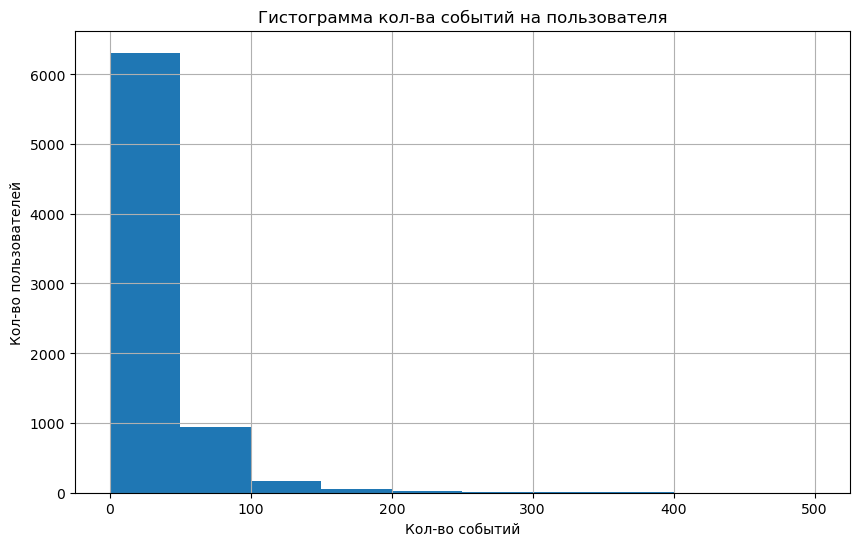

In [19]:
data.groupby('user_id').agg({'eventname':'count'}).hist(bins=10, range=(0,500),figsize=(10,6))
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')
plt.title('Гистограмма кол-ва событий на пользователя')
plt.show()


По гистограмме видим, что большая часть пользователей совершает менее сотни событий, но также есть и те кто делает это до 300. Стоит отметить, что есть аномальные значения в кол-ве 2307 событий на пользователя, при третьем квартиле в 37. Поэтому за среднее кол-во событий будем брать медианное значение - 20 событий.

Далее взглянем за какой период у нас данные

In [20]:
display(f'Максимальная дата события: {max(data.date_time)}',
        f'Минимальная дата события: {min(data.date_time)}')

'Максимальная дата события: 2019-08-07 21:15:17'

'Минимальная дата события: 2019-07-25 04:43:36'

В нашем распоряжении данные за две недели - с 25 июля по 8 августа.

Оценим кол-во событий по дням в разрезе по по группам, чтобы определить период, который будем анализировать. Так как есть вероятность, что не во все даты есть полные данные.

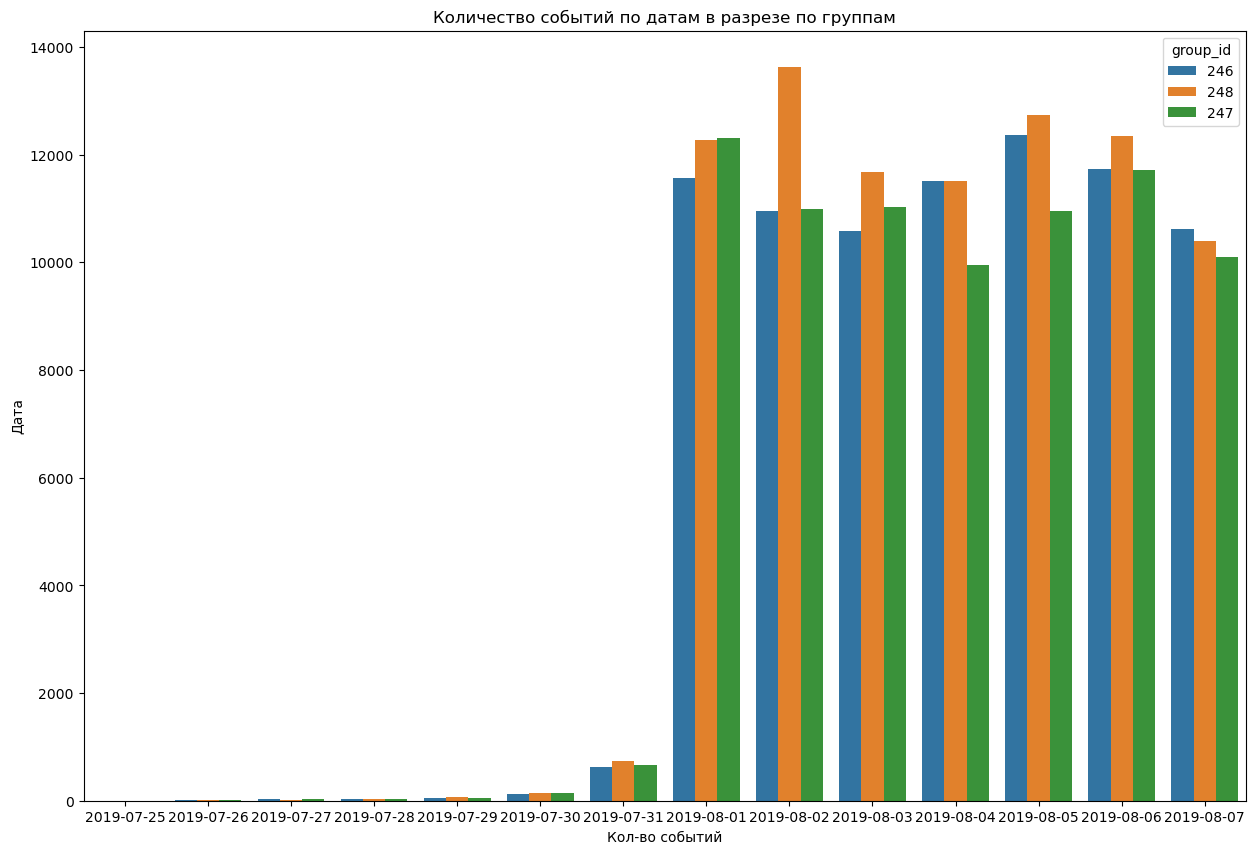

In [21]:
data['group_id'] = data['group_id'].astype('str')
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=data['date'],  data=data, hue='group_id')  
ax.set_title('Количество событий по датам в разрезе по группам')
plt.xlabel('Кол-во событий')
plt.ylabel('Дата')
plt.show()

На полученном графике, видно, что основная масса событий приходиться на период с 01.08 по 07.08. Проверим не превышает ли объем данных за период с 25.07 по 31.07 более ~5%, если нет то даные можно спокойно отбросить.

In [22]:
print('Доля периода с малым кол-вом данных в общем кол-ве:',round(data[data['date'] <= '2019-07-31']['eventname'].count() / data.eventname.count() * 100, 2)),
print('Кол-во отбрасываемых строк:', data[data['date'] <= '2019-07-31']['eventname'].count())
print('Общее кол-во строк:', data.eventname.count())

Доля периода с малым кол-вом данных в общем кол-ве: 1.16
Кол-во отбрасываемых строк: 2826
Общее кол-во строк: 243713


Так как данных всего 1.16%, то убираем их. Но перед эти посмотрим на потери в кол-ве событий и кол-ве пользователей.

In [23]:
print(f'Кол-во событий до актуализации: {data.eventname.count()}')
print(f'Пользователей до актуализации: {data.user_id.nunique()}')

Кол-во событий до актуализации: 243713
Пользователей до актуализации: 7551


In [24]:
irrelevant_events = data[data['date'] <= '2019-07-31']
actual_events = data[data['date'] > '2019-07-31']
irrelevant_users = []
for i in irrelevant_events['user_id'].unique():
    if i in actual_events['user_id'].unique():
        continue
    else:
        irrelevant_users.append(i)

In [25]:
print(f'Будет потеряно событий: {irrelevant_events.eventname.count()}({irrelevant_events.eventname.count()/data.eventname.count():.2%})')
print(f'Будет потеряно пользователей: {len(irrelevant_users)}({len(irrelevant_users)/data.user_id.nunique():.2%})')

Будет потеряно событий: 2826(1.16%)
Будет потеряно пользователей: 17(0.23%)


После удаления устаревших данных получитсья, что мы потеряем 1.16% событий и 0.23% пользователей, что на самом деле, не страшно. Поэтому актуализируем данные

In [26]:
data = data[data['date'] > '2019-07-31']
display(data.head(5),data.shape,
       f'Кол-во событий после актуализации: {data.eventname.count()}', 
        f'Пользователей после актуализации: {data.user_id.nunique()}')

,eventname,user_id,date_time,group_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


(240887, 5)

'Кол-во событий после актуализации: 240887'

'Пользователей после актуализации: 7534'

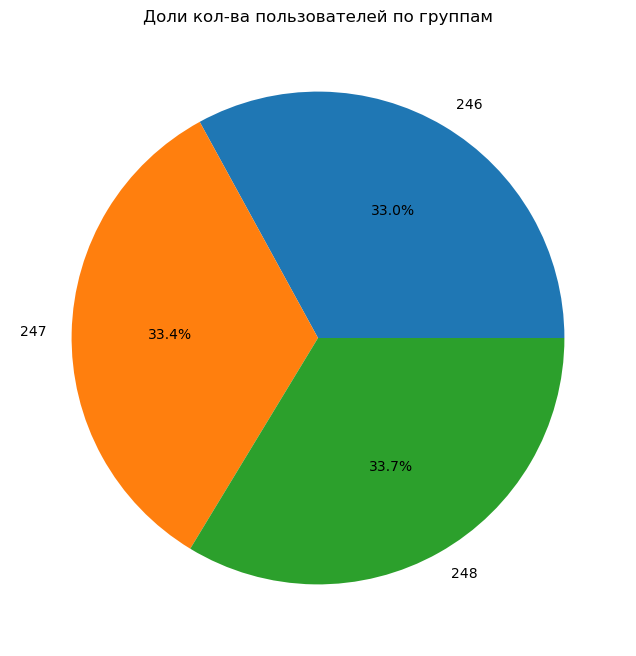

In [27]:
data.groupby('group_id')['user_id'].nunique().plot(kind='pie', title = 'Доли кол-ва пользователей по группам', autopct='%1.1f%%', figsize=(8,8), label='')
plt.show()

Доли уникальных пользователей по группам примерно одинаковые и составляют ~33%. Разница не более чем в 0.7%.

**Ознакомившись с общей информацией о логе, можно сделать промежуточные выводы. Всего событий в логе 243713, число уникальных пользователей 7551. В среднем пользователи совершают около 20 событий, так как в данных есть аномальные значение за этот показатель взяли медианное значение. Изначально данные были за период с 25.07 по 07.08, но построив график событий в разрезе погруппам для каждой даты, обнаружили, что данных за первую неделю очень мало и проверив, что их доля составляет около 1.5 %, актуализировали информацию.**

## Воронка событий

Приступая к изучению воронки событий, первым делом просмотрим как распределены события, какие наиболее часто встречаются.

In [28]:
data.groupby('eventname').agg({'user_id':'count'}).sort_values('user_id',ascending=False)

,user_id
eventname,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Наиболее частое кол-во событий - Просмотр главной страницы. Наименее популярное событие - страница обучения. Просмотр карточки предложения и страница с корзиной имеют примерно одинаково кол-во и чуть менее посещаемая страница с успешной оплатой покупки.

In [29]:
event_table = pd.DataFrame(data.groupby('eventname').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False))
event_table = event_table.rename(columns={'user_id':'count'})
event_table.reset_index(inplace=True)
event_table

,eventname,count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Почти все пользователи совершали событие - посещение главной страницы. Меньше всего пользователей посещали страницу с обучением.
Примерно одинаковое кол-во пользователей были и на странице с успешной оплатой и на странице корзины покупок, страница с товаром имеет чуть больше кол-во посещения уникальных пользователей.

In [30]:
event_table['total_share'] = round(event_table['count'] / data.user_id.nunique() * 100 , 2)
event_table

,eventname,count,total_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Наибольшая доля пользователей от общего числа посещали главную страницу - 98%. Около 10% поcетили страницу с обучением. Около 50 и 47 % пользователей были на странице с корзиной покупок и на странице оплаты картой соответсвенно. И две третих пользователей от общего числа были на странице с картчкой товара.

Выстраивая воронку событий, предположим, что она выглядит вот так:

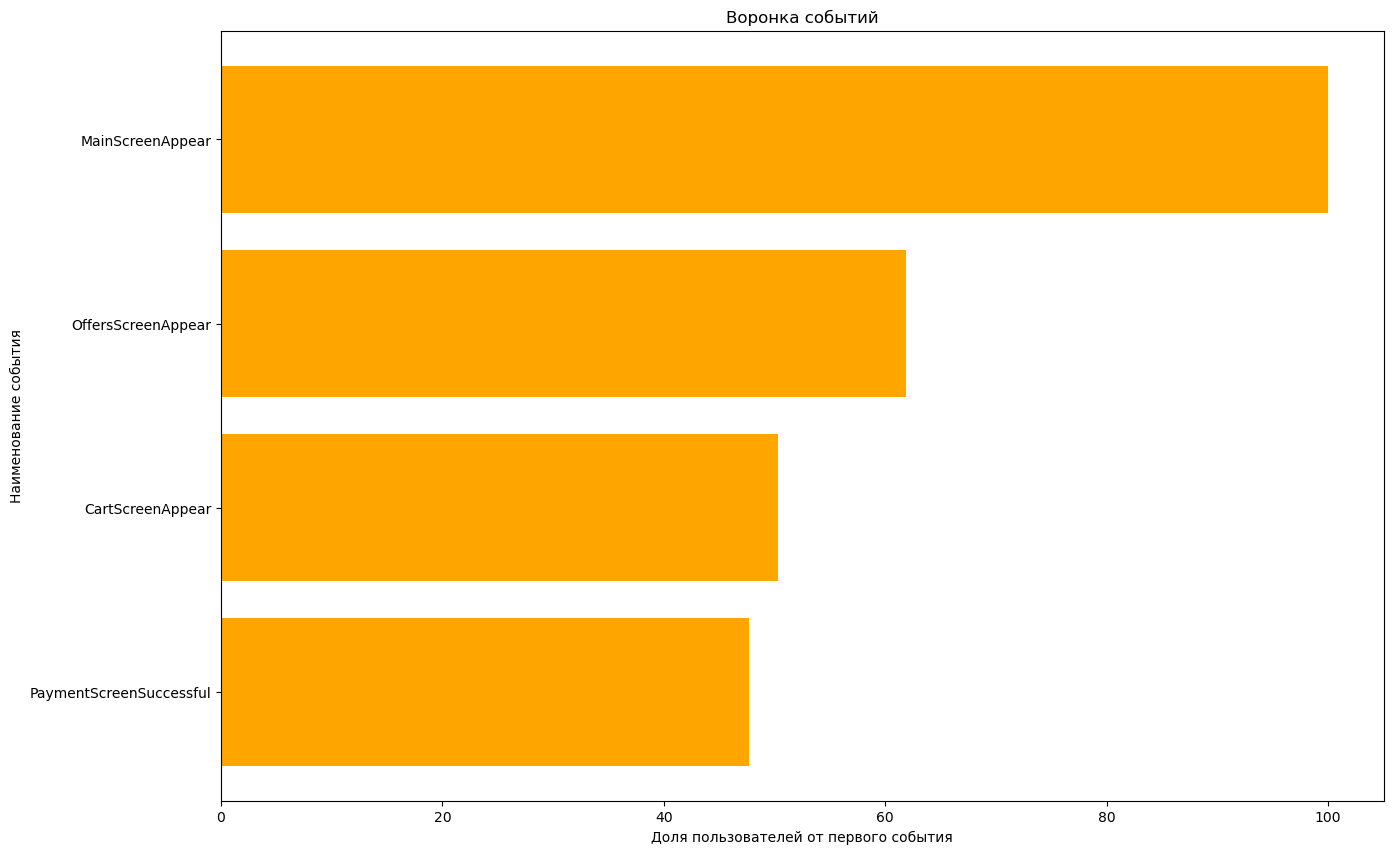

In [31]:
event_table['percentage_by_first'] = round(event_table['count'] / event_table['count'][0] * 100, 2)
funnel_event = event_table.query('eventname != "Tutorial"')[['eventname', 'percentage_by_first', 'count']].sort_values('percentage_by_first', ascending=True)
plt.figure(figsize=(15,10))
plt.barh(funnel_event['eventname'],funnel_event['percentage_by_first'], color = 'orange')
plt.title('Воронка событий')
plt.xlabel('Доля пользователей от первого события')
plt.ylabel('Наименование события')
plt.show()

Итак, у нас получается следующая воронка:

MainScreenAppear -> OffersSreenAppear -> CartScreenApper -> PaymentScreenSuccessful

По итогу получается последовательная, возможно даже в некоторой степени стандартная воронка покупки - вначале пользователь попадает на главную страницу, далее заходит на интересующий его товар, далее добавляет товар в корзину и уже после просмотра корзины оплачивает товар и попадает на страницу с успешной оплатой. В этой воронке пропущена страница Tutorial, т.к. не все пользователи посещают эту страницу, интерфейс довольно простой в освоении, а также это не является обязательным шагом в воронке событий покупки

Далее добавим в таблицу funnel_event долю события от прошлого. Чтобы наглядно увидеть на каком этапе теряется наибольшее кол-во пользователей.

In [32]:
funnel_event = funnel_event.sort_values('count', ascending=False)
funnel_event['pre_share'] = funnel_event['count'].div(funnel_event['count'].shift(1) ,2)
funnel_event['pre_share'] = round(funnel_event['pre_share'] * 100, 2).fillna('-')
funnel_event

,eventname,percentage_by_first,count,pre_share
0,MainScreenAppear,100.00,7419,-
1,OffersScreenAppear,61.91,4593,61.91
2,CartScreenAppear,50.33,3734,81.3
3,PaymentScreenSuccessful,47.70,3539,94.78


В полученной таблице с воронкой событий видно, что наименьшее кол-во пользоватлей с предыдущего события переходило с первого шага на второй, а значит именно здесь пользователя что то смущает и он не переходит к просмотру товара.

Посмотрим на общую долю пользователей, которые прошли от первого события к последнему.

In [33]:
print('Доля пользователей, дошедших до пследнего события:', round(min(funnel_event['count']) / max(funnel_event['count']) * 100 , 2))

Доля пользователей, дошедших до пследнего события: 47.7


**Изначально просмотрев общее кол-во событий по наименованиям, а также кол-во уникальных пользователей на каждом событии, в конечно счете предположили следющую воронку:**

***MainScreenAppear -> OffersSreenAppear -> CartScreenApper -> PaymentScreenSuccessful.***

**Событием с наибольшей долей пользователей, не перешедших на другой шаг, является шаг MainScreenAppear, по сравнению с шагом 2 и 3: ~81 и ~95% оставшихся пользователей с предыдущего шага, говорит о том, что главная страница имеет либо технические проблемы, либо плохо оформленный дизайн/превью товаров, что отталкивает пользователей перейти на саму страницу с карточкой товаров. Общая конверсия "Главная страница/Страница об успешной транзакции" составляет 47.7% довольно высокий показатель, однако есть куда стремиться, тем более с явной проблемой на первом событии.**

## Анализ результатов эксперимента

### Анализ результатов эксперимента

Основной гипотезой A/A/B тестирования является: **"При изменении шрифта кол-во активных уменьшится"**. Именно это мы и будет проверять, сравнивая размеры групп на каждом событии. Приступая к анализу результатов А/А/В, посмотрим сколько пользователей в исследуемых группах.

In [34]:
data.groupby('group_id').agg({'user_id':'nunique'})

,user_id
group_id,
246,2484
247,2513
248,2537


Различия хоть и небольшие, но необходимо проверить корректность всех расчетов и выяснить есть ли статистически значимые различия между группами.

Также посмотрим какое событие для каждой из групп наиболее популярное.

In [35]:
group_246 = data.query('group_id == "246"')
group_247 = data.query('group_id == "247"')
group_248 = data.query('group_id == "248"')

In [36]:
def top_ev(a):
    list_top_ev = a.groupby('eventname').agg({'user_id':'nunique'})
    return print(list_top_ev.sort_values('user_id',ascending=False))
top_ev(group_246)
top_ev(group_247)
top_ev(group_248)

                         user_id
eventname                       
MainScreenAppear            2450
OffersScreenAppear          1542
CartScreenAppear            1266
PaymentScreenSuccessful     1200
Tutorial                     278
                         user_id
eventname                       
MainScreenAppear            2476
OffersScreenAppear          1520
CartScreenAppear            1238
PaymentScreenSuccessful     1158
Tutorial                     283
                         user_id
eventname                       
MainScreenAppear            2493
OffersScreenAppear          1531
CartScreenAppear            1230
PaymentScreenSuccessful     1181
Tutorial                     279


Для всех групп посещение главной страницы является наиболее популярным событием, т.к первый шаг в нашей воронке MainScreenAppear именно здесь и будет больше всего кол-во уникальных пользователей. Далее как и в воронке следует просмотр страницы с товаром, страница с корзиной и страница об успешной оплате. Во всех группах примерно одинаковое кол-во пользователей, но все же маленькие различия есть.        

Проверим являются ли эти различия между группами статистически значимыми. Проверять мы будем по z-значению, целевым действием же выступит каждое событие. Первым делом нам необходимо проверить - являются ли контрольные группы действительно таковыми и есть ли между ними статистически значимые различия.

Введем функцию для проверки статистической значимости различий между выборками к контрольному действию. 

**За значение alpha будем брать 5%.**

In [37]:
def z_test(group_1, group_2, control_name):
    alpha = 0.05
    users_c_event = np.array([group_1[group_1['eventname'] == control_name]['user_id'].nunique(), group_2[group_2['eventname'] == control_name]['user_id'].nunique()])
    users_event = np.array([group_1['user_id'].nunique(), group_2['user_id'].nunique()])
    
    p1 = users_c_event[0] / users_event[0]
    p2 = users_c_event[1] / users_event[1]
    p_combined = (users_c_event[0] + users_c_event[1]) / (users_event[0] + users_event[1])
    
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_event[0] + 1/users_event[1]))
    
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', round(p_value,2))
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else: print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')         

Итак мы ввели функцию, где на входе указываем  группы и контрольное событие. Далее находим кол-во пользователей совершевших  событие в каждой группе и общее кол-во пользователей в группах. После находим пропорции кол-ва пользователей, совершивших  событие к общему кол-ву пользователей и общую пропорцию. Находим z-значение. Задаем стандартное нормально распределение, чтобы в дальнешем использовать его с z-значением и получить результат

Выведем группы и добавим лист с наименованиями событий.

In [38]:
group_246 = data.query('group_id == "246"')
group_247 = data.query('group_id == "247"')
group_248 = data.query('group_id == "248"')
control_event_name = funnel_event['eventname'].unique()
display(group_246.head(5), group_247.head(5), group_248.head(5), control_event_name)

,eventname,user_id,date_time,group_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01


,eventname,user_id,date_time,group_id,date
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
2838,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01
2839,OffersScreenAppear,4899590676214355127,2019-08-01 00:11:30,247,2019-08-01
2843,OffersScreenAppear,4899590676214355127,2019-08-01 00:12:36,247,2019-08-01


,eventname,user_id,date_time,group_id,date
2844,MainScreenAppear,4613461174774205834,2019-08-01 00:14:31,248,2019-08-01
2845,MainScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01
2846,CartScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01
2847,PaymentScreenSuccessful,4613461174774205834,2019-08-01 00:14:43,248,2019-08-01
2848,OffersScreenAppear,4613461174774205834,2019-08-01 00:14:51,248,2019-08-01


array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

Проверим есть ли статистические значимые различия между двумя выборками контрольных групп 246 и 247, проверять будет по каждому событию. Воспользуемся циклом для значений в control_event_name и ранее введенной функцией. Но перед этим сформулируем гипотезы:

- H0 - Доли уникальных пользователей, побывавших на этапе воронки, одинаковы;
- H1 - Между долями уникальных посетителей, побывавших на этапе воронки, есть значимые различия.

In [39]:
for i in control_event_name:
    print('Событиe:', i)
    z_test(group_246, group_247, i)

Событиe: MainScreenAppear
p-значение:  0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: OffersScreenAppear
p-значение:  0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: CartScreenAppear
p-значение:  0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: PaymentScreenSuccessful
p-значение:  0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Доля пользователей совершивших наиболее популярной событие в контрольных группах:

In [40]:
print('Доля пользователей в группе 246:',round(group_246[group_246['eventname'] == 'MainScreenAppear']['user_id'].nunique() / group_246['user_id'].nunique() * 100, 2))
print('Доля пользователей в группе 247:',round(group_247[group_247['eventname'] == 'MainScreenAppear']['user_id'].nunique() / group_247['user_id'].nunique() * 100, 2))

Доля пользователей в группе 246: 98.63
Доля пользователей в группе 247: 98.53


Проверка статистически значимых различий для групп 246 и 247 показало, что различий по всем событиям, в том числе по событию с наибольшем по кол-вом пользователей, а значит эти две группы можно считать контрольными.

Далее проверим контрольные группы с экспериментальной, сравнивать также будем по всем событиям в воронке.

- HO - Различий между долями уникальных пользователей, побывавших на этапе воронки нет, по группам 246 и 248;
- H1 - Между долями уникальных пользователей, побывавших на этапе воронки, по группам 246 и 248 есть статистически значимые различия.

In [41]:
for i in control_event_name:
    print('Событиe:', i)
    z_test(group_246, group_248, i)

Событиe: MainScreenAppear
p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: OffersScreenAppear
p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: CartScreenAppear
p-значение:  0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: PaymentScreenSuccessful
p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как и в случае с контрольными группами, статистически значимых различий между контрольной группой 246 и экспериментальной группой 248 нет, отвергнуть нулевую гипотезу о равнестве мы не можем. В данном случае, это является хорошим показателем, так как скорее всего эксперимент может быть удачным. Проверим есть ли различия между группами 247 и 248.

- HO - Различий между долями уникальных пользователей, побывавших на этапе воронки нет, по группам 247 и 248;
- H1 - Между долями уникальных пользователей, побывавших на этапе воронки, по группам 247 и 248 есть статистически значимые различия.

In [42]:
for i in control_event_name:
    print('Событиe:', i)
    z_test(group_247, group_248, i)

Событиe: MainScreenAppear
p-значение:  0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: OffersScreenAppear
p-значение:  0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: CartScreenAppear
p-значение:  0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: PaymentScreenSuccessful
p-значение:  0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимых различий между группами 247 и 248 нет. Отвергнуть нулевую гипотезу мы не можем.

Далее сравним обе контрольные группы с экспериментальной, возможно будут какие либо изменения.

In [43]:
control_groups = pd.concat([group_246,group_247])
display(control_groups.head(2), control_groups.tail(2))

,eventname,user_id,date_time,group_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01


,eventname,user_id,date_time,group_id,date
244091,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07


- HO - Различий между долями уникальных пользователей, побывавших на этапе воронки, контрольных групп и экспериментальной нет;
- H1 - Между долями уникальных пользователей, побывавших на этапе воронки, по группам есть статистически значимые различия.

In [44]:
for i in control_event_name:
    print('Событиe:', i)
    z_test(control_groups, group_248, i)

Событиe: MainScreenAppear
p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: OffersScreenAppear
p-значение:  0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: CartScreenAppear
p-значение:  0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событиe: PaymentScreenSuccessful
p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как и в случае отдельных сравнений, общяя оценка контрольных групп с экспериментальнйо показала следующий результат - статистически значимых различий между группами нет. Отвергнуть нулевую гипотезу мы не можем.


### Корректировка уровня значимости

Все проверки гипотез были проделаны с 5% уровнем статистической значимости, что является базовым значением. Всего было проделано для 3 групп по **4** проверки (для каждого этапа воронки), сравнивая доли уникальных пользователей между двумя группами, резльтатом всех проверок является - принятие нулевой гипотезы. Так как в данной работе было более 1 теста на одних исходных данных и за один период, то появляется проблема множественной проверки гипотез. Это значит, что в действительности вероятность допустить ошибку и принять неверную гипотезу не 5%, а выше. Введем понятие FWER (групповая вероятность ошибки первого рода). Наиболее популярный метод рассчета FWER является метод Бонферрони:

In [45]:
print(f'При α = 5%, FWER: {round((1 - (1-0.05)**4)*100,2)}%')

При α = 5%, FWER: 18.55%


Значит, что фактическая вероятность допущения ошибки, не 5%, а близится к 19%.

Если мы увеличим уровень статистической значиомсти до 10%, то результаты будут следующие:

In [46]:
print(f'При α = 10%, FWER: {round((1 - (1-0.1)**4)*100,2)}%')

При α = 10%, FWER: 34.39%


При это при всем, скорректированным значением α должно быть:

In [47]:
print(f'α(скорр)={round(1-(1-0.05)**(1/4),4)}')

α(скорр)=0.0127


Обычно такой уровень значимости используется в медицине (1%) для уменьшения вероятности допущения ошибки первого рода. В нашем же исследовании черезчур сильная точность не обязательна, оставим уровень значимости прежним 5%.

### Промежточный итог

**В ходе анализа результатов A/A/B тестирования, просмотрели общее кол-во пользователей по группам, выяснили какие события совершают наибольшее кол-во пользователей, как и в случае с воронкой это - просмотр главной страницы. Используя z-значение оценили выборки между группами по событиям, в результате чего пришли к выводам:**

- Статистически значимых различий между контрольными группами нет, а значит их можно считать таковыми (Нулевая гипотеза не отвергнута);
- Статистически значимых различий между контрольной группой 246 и экспериментальной группой 248 нет (Нулевая гипотеза не отвергнута);
- Статистически значимых различий между контрольной группой 247 и экспериментальной группой 248 нет (Нулевая гипотеза не отвергнута);
- Статистически значимых различий между объединенными контрольными группами (246 и 247) и экспериментальной группой 248 нет (Нулевая гипотеза не отвергнута);

***Так как статистически значимых различий на каждом событии между контрольными группами и экспериментальной нет, можно сделать вывод о том, что на каждом событии группы равны, а значит признать эксперимент удачным и остановить его, так как изначальной гипотезой является - Изменение шрифта уменьшит кол-во активных пользователей.***

## Итог

В начале данной работы в нашем распоряжении был датасет с информацией о пользователях: их идентификационный номер, совершаемое ими событие, дата события, а также номер группы к которой они принадлежат в эксперименте A/A/B тестирования. Нам необходимо было построить предположительную ворону событий, а также понять на каком этапе уходит наибольшая доля пользователей. Также нам предостяло ознакомиться с результатами A/A/B тестирования и проверить являются ли различия в группах статистически значимыми. Далее по плану:

1) Создали переменную с нашим импортированным датасетом, изучили общую информацию по нему;

2) Скорректировали тип данных, изменили названия столбцов, проверили нет ли одинаковых пользователей в разных группах, удалили дубликаты и проверили датафрейм на пропуски, каких не оказалось, добавили дополнительный столбец с датой.

3) Далее изучили общую информацию о пользователях, какие бывают события, за какой период данные. Всего пользователи совершают 5 событий: посещение главной страницы, просмотр страницы товара, обучение на специальной странице, просмотр корзины и страница с успешной транзакцией. Всего событий в логе 243713 с 7551-им уникальным польователем. В среднем полльзователь совершает около 20 событий, но есть и аномальные значения, доходящие до 300 и выше. Изначально данные были за период с 25 июля по 7 августа, но так как часть данных была не полной, то мы отбросили её, доля отбрасываемой части была ~1%, при этом доли кол-ва пользователей из разных групп не изменились.

4) Просмотрев наиболее часто совершаемые события и число уникальных пользователей на каждом этапе построили воронку событий: MainScreenAppear -> OffersSreenAppear -> CartScreenApper -> PaymentScreenSuccessful, Tutorial не входит в общие события т.к. при покупке не является обязательной страницей. Наибольшая доля пользователй, которе уходят от шага к шагу, является первое событие - просмотр главной страницы, около 62% пользоватлеей доживают до следующего этапа. Общая конверсия составляет ~48%, что довольно высокий показатель. 

5) Анализируя результаты эксперимента, применив z-значние и сравнив выборки между группами на каждом событии можно прийти к следующему:

    -Контрольные группы сформированы корректно и на каждом событии в воронке статистически значимых различий между группами нет;
    -Как и в случае с объединенными контрольными группами, так и по отдельности, но между 246, 247, 248(экспериментальная группы) статистически значимых разичий нет
    -Так как различий нет, то можно признать эксперимент удачным и завершить его, результатом которого является- после изменения шрифта кол-во активных пользователей не изменяется.
    
**Общие пожелания и рекоммендации:**

   **В целом данные были довольно "чистые" и масштабных изменений или пропусков не было, были дубликаты, но на дальнейшую работу никак не повлияли. Все переменные и столбцы были использованны, дополнительно потребовалось лишь ввести отдельно столбец с датой.**
    
   **Отдельно по воронке, так как главная страница является визитной карточкой компаний и первое, что видит будущий покупатель, ей стоит уделить особое внимание, возможно стоит пересмотреть дизайн фото презентаций продуктов, либо же добивить краткое описание или короткие промо ролики для заинтерисованности, возможно изменить витрину товаров и на верхние строчки поднимать наиболее популярные товары, чтобы привлекать пользователя. Из всех возможных вариантов стоит обсудить с отделом маркетинга и дизайна и определить какой из вариантов будет наименее затратный и с высоким профитом, также возмжно провести экспертное или проблемное интервью, а далее выдвинуть гипотезы и проверить изменения с использованием A/B теста. Важным замечанием яляется, что это все стоит делать только после проверки технической исправности главной страницы.**
    
   **Пару слов по результатом A/A/B тестирования, хоть результаты и оказались положительными - изменение шрифта не влияет на кол-во активных пользователей, но это не значит, что необходимо сразу вводить изменения на всех пользователей. Так как все же основной целью бизнеса является получение прибыли, стоит проверить повлияет ли изменение шрифта на изменение денежных метрик таких как: читая прибыль, LTV, ARPU, ARPPU, среднее кол-во позиций в заказе и другие. Да, кол-во пользователей, перешедших на страницу с успешной транзакцией не изменилось, но метрики кол-ва пользователей не значительно оценивают кол-во денежных средств в обороте. Возможно и на такие метрики как DAU и MAU изменение не повлияет, но стоит помнить, что это может оттолкнуть пользователей от увеличения корзины и выбора в сторону более дорогих товаров.**